In [80]:
import logging
from utils import logging as lg

lg.set_logging()

In [81]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math

from utils import data_provider
from utils import experiment_artifact
from notebook_utils import plot
plot.setup()

2017-10-12 06:26:22,846 | INFO : plot.py(setup 14) - Setup plot parameters


# Data Preparation

In [3]:
X_train, Y_train = data_provider.get_mnist('train', dir_path='../data/mnist')
X_test, Y_test = data_provider.get_mnist('test', dir_path='../data/mnist')

2017-10-10 14:18:31,132 | INFO : data_provider.py(get_mnist 17) - Load MNIST : train
2017-10-10 14:18:31,540 | INFO : data_provider.py(get_mnist 17) - Load MNIST : test


In [4]:
X_train_2d = np.copy(X_train.reshape((-1,28,28)))
X_test_2d = np.copy(X_test.reshape((-1,28,28)))

2017-10-10 14:18:32,321 | INFO : plot.py(show_and_save 21) - save fig to ../figures/nb_figures/mnist-label5-with-cols.png


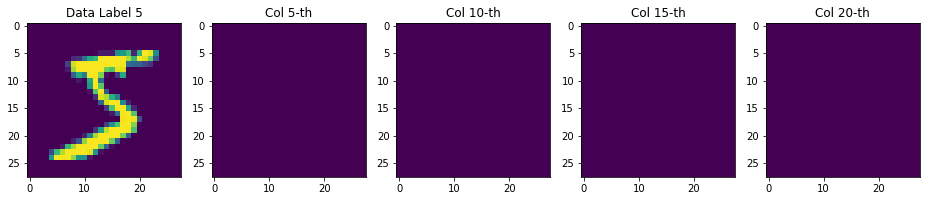

In [5]:
def plot_mnist_with_columns(data_idx, col_indices):
    plt.figure(figsize=(16,3))

    plt.subplot(1,5,1)

    plt.imshow(X_train[data_idx,:].reshape((28,28)))
    plt.title('Data Label %d' % int(np.sum(np.arange(10) * Y_train[data_idx,:])))

    count = 2
    for col_idx in col_indices:
        plt.subplot(1,5,count)
        img_zero = np.zeros((28,28))
        img_zero[:, col_idx] = X_train_2d[data_idx, :, col_idx]
        plt.title('Col %d-th' % col_idx)
        plt.imshow(img_zero, vmin=0, vmax=255)
        count = count + 1
plot_mnist_with_columns(data_idx = 0, col_indices = [5, 10,15,20])
plt.show_and_save(title='mnist-label5-with-cols.png');

In [17]:
def batch_data(x, y, n=1):
    l = len(x)
    for ndx in range(0, l, n):
        yield (x[ndx:min(ndx + n, l)],  y[ndx:min(ndx + n, l)])

class Layer:
    def __init__(self, dims, name, stddev=0.1):
        weights = tf.Variable(
            tf.truncated_normal(dims, stddev=stddev),
            name="%s_weights"%name
        )

        bias = tf.Variable(
            tf.zeros(dims[1]),
            name="%s_bias"%name
        )
        
        self.W = weights
        self.b = bias

# Training

## Network Architecture
![image.png](https://i.imgur.com/LjLKm7S.png)


### Notations
- $\boldsymbol{x}^{(\alpha)}_{(\cdot,tk:(t+1)k-1)}$  : sample $\alpha$ with all rows of columns $tk$ to $(t+1)k-1$ and reshaped to a column vector
    - $k \in \{1,4,7,14,28\}$
    - $t = \{1, \dots, \frac{28}{k} \}$
- $\boldsymbol{W}_{in}$, $\boldsymbol{b}_{in}$ : weights and bias of input representation layer $\boldsymbol{I}^{(\alpha)}_t$
$$
\boldsymbol{I}^{(\alpha)}_t = \text{RELU} \bigg( \boldsymbol{x}^{(\alpha)}_{(\cdot,tk:(t+1)k-1)} \boldsymbol{W}_{in} + \boldsymbol{b}_{in}  \bigg)
$$
- $\boldsymbol{r}^{(\alpha)}_{t}$ : recurrent inputs of column $t$ of sample $\alpha$
- $\widetilde{\boldsymbol{I}}^{(\alpha)}_{t}$ : concatenation of $\boldsymbol{I}^{(\alpha)}_{t}$  and $\boldsymbol{r}_{t}$
- $\boldsymbol{W}_{h}$, $\boldsymbol{b}_{h}$ : weights and bias of cell hidden layer $\boldsymbol{H}^{(\alpha)}_t$
$$
\boldsymbol{H}^{(\alpha)}_t = \text{RELU} \bigg( \widetilde{\boldsymbol{I}}^{(\alpha)}_{t} \boldsymbol{W}_{h} + \boldsymbol{b}_{h}  \bigg)
$$
- $\boldsymbol{W}_{r}$, $\boldsymbol{b}_{r}$ : weights and bias for recurrent unit activations $\boldsymbol{r}^{(\alpha)}_{t+1}$
$$
\boldsymbol{r}^{(\alpha)}_{t+1} = \text{RELU} \bigg( \boldsymbol{H}^{(\alpha)}_t \boldsymbol{W}_{r} + \boldsymbol{b}_{r}  \bigg)
$$
- $\boldsymbol{W}_{o1}$, $\boldsymbol{b}_{o1}$ : weights and bias of 1st output layer $\boldsymbol{O}^{(\alpha)}_t$
$$
\boldsymbol{O}^{(\alpha)}_t = \text{RELU} \bigg( \boldsymbol{H}^{(\alpha)}_t \boldsymbol{W}_{o1} + \boldsymbol{b}_{o1}  \bigg)
$$
- $\boldsymbol{W}_{o2}$, $\boldsymbol{b}_{o2}$ : weights and bias of 2nd output layer $\hat{\boldsymbol{O}}^{(\alpha)}_t$
$$
\hat{\boldsymbol{O}}^{(\alpha)}_t = \text{RELU} \bigg( \boldsymbol{O}^{(\alpha)}_t \boldsymbol{W}_{o2} + \boldsymbol{b}_{o2}  \bigg)
$$
- $\hat{\boldsymbol{y}}^{(\alpha)}$ : class predictions of $\boldsymbol{x}^{(\alpha)}$
$$
\hat{\boldsymbol{y}}^{(\alpha)} = \text{SOFTMAX} \bigg( \hat{\boldsymbol{O}}^{(\alpha)}_{\text{max}(t)}  \bigg) 
$$

## Training Parameters

In [38]:
# These parameters are choosed arbitrarily.
NETWORK_PARAMS = {
    'input_max_seq_length': 28,
    'input_dims': 28,
    
    'learning_rate': 0.005,
    'batch_size': 100,
    
    'pior_cell_layer_units': 100,
    'hidden_units': 60,
    'pior_output_units': 50,
    'output_units': 10,
    'recurrent_units': 20,
}

## Implementation

In [40]:
def train_and_evaluate(seq_length=1, epoch=2, _lr=NETWORK_PARAMS['learning_rate'], debug=False):
    no_input_cols = NETWORK_PARAMS['input_max_seq_length'] // seq_length
    logging.info('Training %d columns at a time' % no_input_cols)

    recurrent_inputs = tf.placeholder(tf.float32, shape=(None, NETWORK_PARAMS['recurrent_units']))


    ly_input_1   = Layer((NETWORK_PARAMS['input_dims']*no_input_cols, NETWORK_PARAMS['pior_cell_layer_units']), 'input')
    ly_input_2   = Layer((NETWORK_PARAMS['pior_cell_layer_units'] +NETWORK_PARAMS['recurrent_units'] , NETWORK_PARAMS['hidden_units']), 'input_tc')
    
    ly_output_1  = Layer((NETWORK_PARAMS['hidden_units'], NETWORK_PARAMS['pior_output_units']), 'pior_output')
    ly_output_2  = Layer((NETWORK_PARAMS['pior_output_units'], NETWORK_PARAMS['output_units']), 'output')
    
    ly_recurrent = Layer((NETWORK_PARAMS['hidden_units'], NETWORK_PARAMS['recurrent_units']), 'recurrent')


    x_input = tf.placeholder(tf.float32, shape=(None, NETWORK_PARAMS['input_dims'], NETWORK_PARAMS['input_dims']))
    y_ = tf.placeholder(tf.float32, [None, 10])

    rr = recurrent_inputs
    

    for i in range(0, x_input.shape[1], no_input_cols):
        ii = tf.reshape(x_input[:,i:i+no_input_cols], [-1, no_input_cols * NETWORK_PARAMS['input_dims'] ])
        itc = tf.nn.relu(tf.matmul(ii, ly_input_1.W) + ly_input_1.b)
        
        xr = tf.concat([itc, rr], axis=1)
        ha = tf.nn.relu(tf.matmul(xr, ly_input_2.W) + ly_input_2.b)

        rr = tf.nn.relu(tf.matmul(ha, ly_recurrent.W) + ly_recurrent.b)
        
        ho = tf.nn.relu(tf.matmul(ha, ly_output_1.W) + ly_output_1.b)
        ot = tf.matmul(ho, ly_output_2.W) + ly_output_2.b
        
    y = ot

    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_))

    train_op = tf.train.AdamOptimizer(learning_rate=_lr).minimize(loss_op)

    init_op = tf.global_variables_initializer()

    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    with tf.Session() as sess:
        sess.run(init_op)

        step = 1
        for i in range(epoch):
            logging.info('epoch %d' % (i+1))
            for xf, yf in batch_data(X_train_2d, Y_train, n=NETWORK_PARAMS['batch_size']):
        
                rr = np.zeros((NETWORK_PARAMS['batch_size'], NETWORK_PARAMS['recurrent_units']))
                sess.run(train_op, feed_dict={x_input: xf, y_: yf, recurrent_inputs: rr})
                
                if (step % 1000 == 0 or step < 10) and debug:
                    rr = np.zeros((len(yf), NETWORK_PARAMS['recurrent_units']))
                    acc, loss = sess.run([accuracy, loss_op], feed_dict={x_input: xf, y_: yf, recurrent_inputs:rr})
                    logging.info('step %d : train acc %f, loss %f' % (step, acc, loss))
                    
                step = step + 1
                
        rr = np.zeros((len(Y_test), NETWORK_PARAMS['recurrent_units']))
        acc = sess.run(accuracy, feed_dict={x_input: X_test_2d, y_: Y_test, recurrent_inputs: rr})
        
        res = dict(
            seq_length = seq_length,
            epoch = epoch,
            column_at_a_time = no_input_cols,
            accuracy = acc,
            **NETWORK_PARAMS
        )
        
        return res
    
res = train_and_evaluate(seq_length=14, epoch=10)

plot.tabularize_params(res)

2017-10-10 15:00:21,272 | INFO : <ipython-input-40-210fb1765345>(train_and_evaluate 3) - Training 2 columns at a time
2017-10-10 15:00:27,209 | INFO : <ipython-input-40-210fb1765345>(train_and_evaluate 51) - epoch 1
2017-10-10 15:00:27,340 | INFO : <ipython-input-40-210fb1765345>(train_and_evaluate 60) - step 1 : train acc 0.180000, loss 2.296820
2017-10-10 15:00:27,354 | INFO : <ipython-input-40-210fb1765345>(train_and_evaluate 60) - step 2 : train acc 0.200000, loss 2.295113
2017-10-10 15:00:27,367 | INFO : <ipython-input-40-210fb1765345>(train_and_evaluate 60) - step 3 : train acc 0.190000, loss 2.288708
2017-10-10 15:00:27,382 | INFO : <ipython-input-40-210fb1765345>(train_and_evaluate 60) - step 4 : train acc 0.160000, loss 2.277057
2017-10-10 15:00:27,397 | INFO : <ipython-input-40-210fb1765345>(train_and_evaluate 60) - step 5 : train acc 0.160000, loss 2.272106
2017-10-10 15:00:27,415 | INFO : <ipython-input-40-210fb1765345>(train_and_evaluate 60) - step 6 : train acc 0.140000, 

,attribute,value
12,accuracy,0.9227
10,batch_size,100.0000
5,column_at_a_time,2.0000
11,epoch,10.0000
9,hidden_units,60.0000
1,input_dims,28.0000
2,input_max_seq_length,28.0000
4,learning_rate,0.0050
8,output_units,10.0000
6,pior_cell_layer_units,100.0000


# Experiments
Command for running experiments

```
$ python scripts/train.py s3-network --seq-length 7 --epoch 50 --lr 0.005 --batch 100 \
--architecture-str 'in1:100|hidden:60|out1:30|out2:10--recur:7' --verbose --result_dir ./experiment-results/sprint-2
```

## Results

In [77]:
df_results = experiment_artifact.get_results('../experiment-results/sprint-2').sort_values(by='accuracy', ascending=False)

In [72]:
# 4 columns at a time
df_results[df_results.seq_length==7][:5]

,accuracy,architecture_name,column_at_a_time,epoch,experiment_name,layer_hidden,layer_in1,layer_out1,layer_out2,layer_recur,lr,seq_length
12,0.9722,s3_network,4,50,rnn-2017-10-10--23-47,60,100,30,10,7,NaN,7
39,0.9716,s3_network,4,50,rnn-2017-10-11--00-28,60,80,50,10,10,NaN,7
17,0.9712,s3_network,4,50,rnn-2017-10-10--23-56,60,100,50,10,10,NaN,7
22,0.9711,s3_network,4,50,rnn-2017-10-11--00-04,60,100,30,10,10,NaN,7
2,0.9705,s3_network,4,50,rnn-2017-10-10--22-59,60,100,50,10,7,NaN,7


In [73]:
# 2 columns at a time
df_results[df_results.seq_length==14][:5]

,accuracy,architecture_name,column_at_a_time,epoch,experiment_name,layer_hidden,layer_in1,layer_out1,layer_out2,layer_recur,lr,seq_length
60,0.9473,s3_network,2,10,rnn-2017-10-11--14-44,60,50,30,10,20,NaN,14
69,0.9451,s3_network,2,50,rnn-2017-10-11--15-02,60,30,50,10,7,NaN,14
84,0.9417,s3_network,2,20,rnn-2017-10-11--15-29,60,30,30,10,20,NaN,14
57,0.9394,s3_network,2,20,rnn-2017-10-11--14-36,60,50,50,10,20,NaN,14
76,0.9388,s3_network,2,10,rnn-2017-10-11--15-15,60,30,50,10,20,NaN,14


In [79]:
# 1 col at a time
df_results[df_results.seq_length==28][:5]

,accuracy,architecture_name,column_at_a_time,epoch,experiment_name,layer_hidden,layer_in1,layer_out1,layer_out2,layer_recur,lr,seq_length
90,0.8769,s3_network,1,20,rnn-2017-10-11--15-42,60,20,50,10,20,0.005,28
88,0.8212,s3_network,1,10,rnn-2017-10-11--15-39,60,20,50,10,20,0.005,28
114,0.7539,s2_network,1,20,rnn-2017-10-11--16-59,60,10,50,10,20,0.005,28
130,0.7386,s2_network,1,10,rnn-2017-10-11--17-50,60,10,30,10,40,0.005,28
128,0.7205,s2_network,1,50,rnn-2017-10-11--17-43,60,10,50,10,40,0.005,28


# Summary

# Code For Testing

In [23]:
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets("../data/mnist", one_hot=True)

In [31]:
# def build_layer(dims,name):
#     weights = tf.Variable(
#         tf.truncated_normal(dims, stddev=0.1),
#         name="%s_weights"%name
#     )

#     bias = tf.Variable(
#         tf.zeros(dims[1]),
#         name="%s_bias"%name
#     )
#     return weights, bias

In [21]:
# def simple_relu_net():
#     learning_rate=0.1
#     x_input = tf.placeholder(tf.float32, shape=(None, NETWORK_PARAMS['input_dims']*NETWORK_PARAMS['input_dims']))
#     y_ = tf.placeholder(tf.float32, [None, 10])

#     l1_w, l1_b = build_layer((784,256), 'l1')
#     lx_w, lx_b = build_layer((256,256), 'lx')
#     l2_w, l2_b = build_layer((256,10), 'l2')
    
#     mt = tf.nn.relu(tf.matmul(x_input, l1_w) + l1_b )
#     gg = tf.nn.relu(tf.matmul(mt, lx_w) + lx_b )
#     ot = tf.matmul(gg, l2_w) + l2_b
     
#     y = ot

#     loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_))
#     optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
#     train_op = optimizer.minimize(loss_op)

#     with tf.Session() as sess:
#         sess.run(tf.global_variables_initializer())
        
#         correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
#         accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#         for i in range(500):
#             batch = mnist.train.next_batch(128)
            
#             sess.run(train_op, feed_dict={x_input: batch[0], y_: batch[1]})
            
#             if i % 100 == 0 or i == 1:
                
#                 acc, loss = sess.run([accuracy, loss_op], feed_dict={x_input: batch[0], y_: batch[1]})
#                 print('Loss %f, training acc %f)' %(loss, acc))
# #                 print("Train Accuracy : %.4f" % sess.run(accuracy, feed_dict={x_input: X_train_2d.reshape(-1,28*28), y_: Y_train}))
# #                 print("Train Accuracy : %.4f" % sess.run(accuracy, feed_dict={x_input: mnist.train.images, y_: mnist.train.labels}))
#         print('Test acc %f' % sess.run(accuracy, feed_dict={x_input: mnist.test.images, y_: mnist.test.labels}))
# simple_relu_net()

In [41]:
from datetime import datetime

In [46]:
datetime.now().strftime('%Y-%m-%d--%H-%M')

'2017-10-10--22-12'